<a href="https://colab.research.google.com/github/urbinaticri/GraphNeuralNetworks/blob/main/Graph_Node_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Node Classification in Pytorch via message passing

---

The goal of this work is to model a Graph Neural Network to perform Node Classification that can fit different non-trivial datasets and possibly real world scenarios. The idea is to try different network structures and model a training function that automatically finds the best configuration of hyperparameters that can fit a certain task.

## Environment configuration and imports
In order to achieve our goal, we need to install some requirements such as the pytorch geometric utils that give access to a variety of implemented classes and functions about GNN

In [ ]:
%%capture
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx

import time
import math
import random
import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

from sklearn.manifold import TSNE

We also check if gpu is available, in this way we will be able to perform training faster

In [ ]:
device = 'cpu'
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  

All good, a Gpu is available


In [ ]:
!nvidia-smi

Wed Mar 23 14:08:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Reproducibility
When **developing and debugging** Neural Networks is desirable to have a deterministic behaviour. For this reason, we are going to disable all the sources of randomness. Please note that completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. You can find more detailed information at this [page](https://pytorch.org/docs/stable/notes/randomness.html).
Please note that the flag `cudnn.benchmark = False` disable the auto-tuner that selects the optimal set of algorithms for your hardware and usually leads to slower runtime. 

In [ ]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True        

In [ ]:
fix_random(42)

## The dataset
The datasets we will use in the experiments are the ones offered by torch_geometrics, we can explore the list in that [page](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets).

We will also visualize the data and perform some analysis and statistics about their distribution to see if some network structures works better in some scenarios with respect tot other.

In [ ]:
#from torch_geometric.datasets import KarateClub
#dataset = KarateClub()

from torch_geometric.datasets import Planetoid
dataset = Planetoid(root=".", name="Cora", split="full")

Processing...
Done!


In [ ]:
print("Dataset name:", dataset)
print("# Graphs:", len(dataset))
print("# Node features:", dataset.num_features)
print("# Classes:", dataset.num_classes)

Dataset name: Cora()
# Graphs: 1
# Node features: 1433
# Classes: 7


In [ ]:
data = dataset[0]
print(data)
print("Training nodes:", data.train_mask.sum().item(), "/", data.num_nodes)
print("Is directed:", data.is_directed())

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Training nodes: 1208 / 2708
Is directed: False


Let's see if class are balanced or not across the splits:

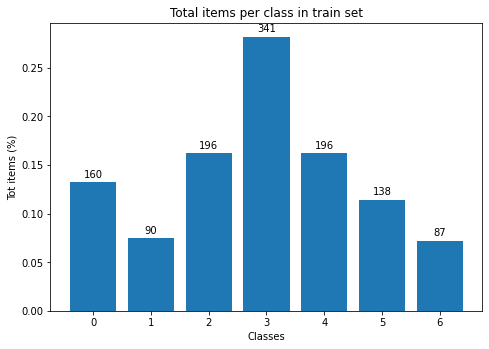

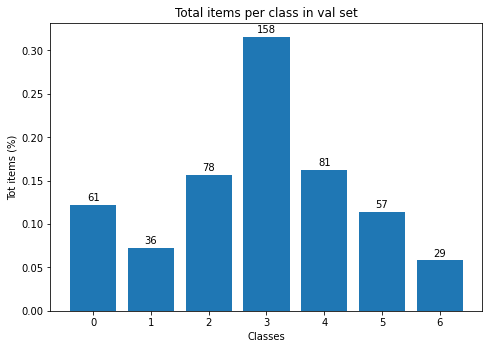

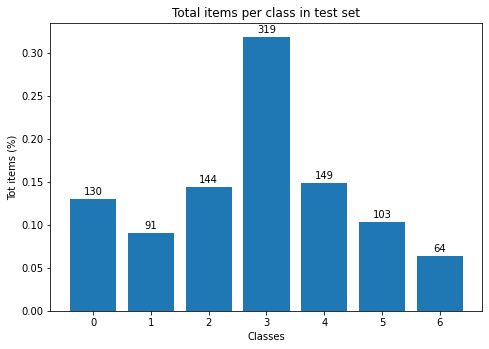

In [ ]:
def plot_total_per_class(dataset, split):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    classes = [c for c in range(dataset.num_classes)]
    totals = [0 for c in range(dataset.num_classes)]

    for i in range(len(dataset)):
        graph = dataset[i]
        split_mask = {
        'train' : graph.train_mask,
        'val': graph.val_mask,
        'test': graph.test_mask,
        }
        items = [graph.y[split_mask[split]].tolist().count(i) for i in classes ]
        totals = [x + y for x, y in zip(totals, items)]

    normalized_totals = [float(x) / np.sum(totals) for x in totals]
    bars = ax.bar(classes, normalized_totals)

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + .005, totals[i], ha='center')

    plt.xlabel('Classes')
    plt.ylabel('Tot items (%)')
    plt.title(f"Total items per class in {split} set")
    plt.show()

for split in ['train', 'val', 'test']:
    plot_total_per_class(dataset, split)

Classes are well balanced in this case so we can use the accuracy as metric for models evaluation

Let's plot the structure of the first graph in the dataset:

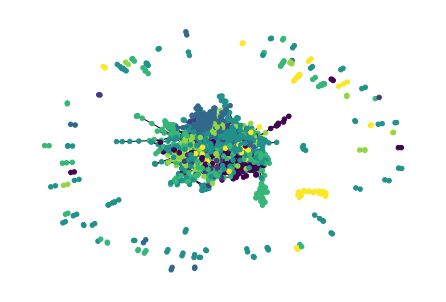

In [ ]:
G = to_networkx(data, to_undirected=True)
nx.draw(G, node_color=data.y, node_size=20)

# Train and evaluate functions

The train function performs 10 trials resetting each time the model weights and running a training for 100 epochs, after each epoch a validation phase is performed. The metric used is the accuracy since the problem has balanced classes.

Early stopping is performed in order to prevent the model to overfit on train set, in particular, if the accuracy on validation set get worse cosecutively for more time than the patience the train is aborted.

The train funcion returns the weights of the best model alongside its corresponding history and embeddings.

The test function performs the evaluation of the model in terms of accuracy.

In [ ]:
def train(model, optimizer, loss_fn, data, trials=1, epochs=20, patience=5, device='cuda'):

    print('Train: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    start_time_sec = time.time()

    best_model_weights = None
    best_model_embeddings = None
    best_model_history = None

    best_val_acc = 0

    for trial in range(trials):
        print('Trial %d:' % (trial+1))
        model.reset_parameters()

        trigger_times = 0
        last_val_acc = 0

        history = {}
        history['loss'] = []
        history['val_loss'] = []
        history['acc'] = []
        history['val_acc'] = []

        embeddings = []

        for epoch in range(epochs):

            # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
            model.train()
            train_loss         = 0.0
            num_train_correct  = 0
            num_train_examples = 0

            optimizer.zero_grad()

            yhat = model(data.x, data.edge_index)
            train_loss = loss_fn(yhat[data.train_mask], data.y[data.train_mask])

            train_loss.backward()
            optimizer.step()

            num_train_correct  += (torch.max(yhat[data.train_mask], 1)[1] == data.y[data.train_mask]).sum().item()
            num_train_examples += data.y[data.train_mask].shape[0]

            train_acc   = num_train_correct / num_train_examples

            embeddings.append(yhat)

            # --- EVALUATE ON VALIDATION SET -------------------------------------
            model.eval()
            val_loss       = 0.0
            num_val_correct  = 0
            num_val_examples = 0

            with torch.no_grad():
                yhat = model(data.x, data.edge_index)
                val_loss = loss_fn(yhat[data.val_mask], data.y[data.val_mask])

                num_val_correct  += (torch.max(yhat[data.val_mask], 1)[1] == data.y[data.val_mask]).sum().item()
                num_val_examples += data.y[data.val_mask].shape[0]

                val_acc  = num_val_correct / num_val_examples

            if (epoch + 1) % 10 == 0 or epoch == 0 :
                print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch+1, epochs, train_loss, train_acc, val_loss, val_acc))

            history['loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['acc'].append(train_acc)
            history['val_acc'].append(val_acc)

            

            # Early stopping
            if history['val_acc'][-1] < last_val_acc:
                trigger_times += 1
                if trigger_times >= patience:
                    print('Early stopping: stop training')
                    break
            else:
                trigger_times = 0
                last_val_acc = history['val_acc'][-1]
            
                if last_val_acc > best_val_acc:
                    best_model_weights = model.state_dict()
                    best_val_acc = last_val_acc
                    best_model_embeddings = embeddings
                    best_model_history = history

        # END OF TRAINING LOOP
        

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))

    return best_model_history, best_model_weights, best_model_embeddings

def test(model, data, device='cuda'):
    model.eval()
    num_test_correct  = 0
    num_test_examples = 0

    with torch.no_grad():
        yhat = model(data.x, data.edge_index)

        num_test_correct  += (torch.max(yhat[data.test_mask], 1)[1] == data.y[data.test_mask]).sum().item()
        num_test_examples += data.y[data.test_mask].shape[0]

        test_acc  = num_test_correct / num_test_examples

    return test_acc

#Models definition
In the following sections we are going to perform several experiments using different model structures 

In [ ]:
# Shared global variables
HIDDEN_DIM = 16
OUTPUT_DIM = dataset.num_classes
DROPOUT = 0.3
EPOCHS = 100
NTRIALS = 10

## Experiment #1: GCN

In the first experiment we deal with a Graph Convolutional Network based on [Message Passing](https://arxiv.org/abs/1704.01212).

Here the GCN is matematically defined as:
$$x_{i}^{(k)} = \sum_{j \in \mathcal{N(i)} \cup \{i\}} \frac{1}{\sqrt{\deg(i)} \cdot \sqrt{\deg(j)}} \cdot \left(  \Theta^{\top} \cdot x_{j}^{(k-1)}\right)$$
where neighboring node features are first transformed by a weight matrix $\Theta$, normalized by their degree, and finally summed up. This formula can be divided into the following steps:
1. Add self-loops to the adjacency matrix.
2. Linearly transform node feature matrix.
3. Compute normalization coefficients.
4. Normalize node features in $\phi$.
5. Sum up neighboring node features ("add" aggregation).

Source: [pytorch geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html)

In [ ]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, degree
from torch_geometric.nn.dense.linear import Linear

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.linear = Linear(in_channels, out_channels, bias=False, weight_initializer='glorot')
    
    def reset_parameters(self):
        self.linear.reset_parameters()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.linear(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

Starting from the convolution layer defined above we build a model which architecture is inspired to [SSP](https://github.com/russellizadi/ssp) that currently achieves the SOTA for node classification on Cora dataset and also achieves top ranking position in other datasets like Citeseer and Pubmed.

The network is constituted by two blocks:
- CRD: performs a graph convoltion followed by a ReLU activation and a dropout layer.
- CLS: performs a graph concolution followed by a log softmax activation.

In [ ]:
class CRD(torch.nn.Module):
    def __init__(self, in_channels, out_channels, p):
        super(CRD, self).__init__()
        self.conv = GCNConv(in_channels, out_channels) 
        self.p = p

    def reset_parameters(self):
        self.conv.reset_parameters()

    def forward(self, x, edge_index):
        h = F.relu(self.conv(x, edge_index))
        h = F.dropout(h, p=self.p)
        return h

class CLS(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CLS, self).__init__()
        self.conv = GCNConv(in_channels, out_channels)

    def reset_parameters(self):
        self.conv.reset_parameters()

    def forward(self, x, edge_index):
        h = self.conv(x, edge_index)
        h = F.log_softmax(h, dim=1)
        return h

class GNCNet(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, p_drop):
        super(GNCNet, self).__init__()
        self.crd = CRD(in_dim, hid_dim, p_drop)
        self.cls = CLS(hid_dim, out_dim)

    def reset_parameters(self):
        self.crd.reset_parameters()
        self.cls.reset_parameters()

    def forward(self, x, edge_index):
        h = self.crd(x, edge_index)
        h = self.cls(h, edge_index)
        return h

model = GNCNet(dataset.num_features, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

embedding = model(data.x, data.edge_index)
print("Embedding shape:", embedding.shape)

Embedding shape: torch.Size([2708, 7])


In [ ]:
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

history, best_model_weights, best_model_embedding = train(model, optimizer, criterion, data, trials=NTRIALS, epochs=EPOCHS, device=device)

model.load_state_dict(best_model_weights)
print()
print(f'Best model predicts with {test(model, data, device=device):.2f} accuracy on test set')

Train: model=GNCNet, opt=Adam(lr=0.010000), epochs=100, device=cuda:0

Trial 1:
Epoch   1/100, train loss:  1.95, train acc:  0.11, val loss:  1.85, val acc:  0.39
Epoch  10/100, train loss:  1.02, train acc:  0.75, val loss:  1.02, val acc:  0.71
Epoch  20/100, train loss:  0.46, train acc:  0.88, val loss:  0.59, val acc:  0.84
Epoch  30/100, train loss:  0.27, train acc:  0.93, val loss:  0.49, val acc:  0.86
Early stopping: stop training
Trial 2:
Epoch   1/100, train loss:  1.93, train acc:  0.14, val loss:  1.91, val acc:  0.17
Epoch  10/100, train loss:  1.43, train acc:  0.48, val loss:  1.41, val acc:  0.51
Epoch  20/100, train loss:  0.71, train acc:  0.85, val loss:  0.79, val acc:  0.83
Early stopping: stop training
Trial 3:
Epoch   1/100, train loss:  1.95, train acc:  0.14, val loss:  1.94, val acc:  0.13
Epoch  10/100, train loss:  1.25, train acc:  0.73, val loss:  1.23, val acc:  0.74
Epoch  20/100, train loss:  0.52, train acc:  0.88, val loss:  0.64, val acc:  0.83
Ea

Finally TSNE is used to obtain a representation in lower dimensions to have an idea of how faster the model is learning

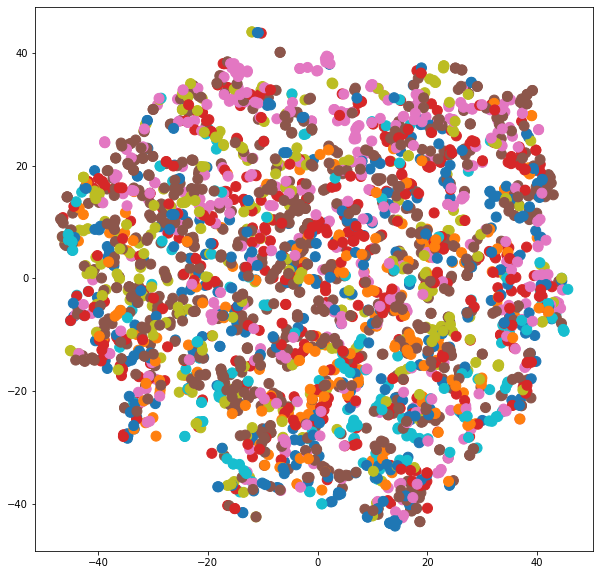

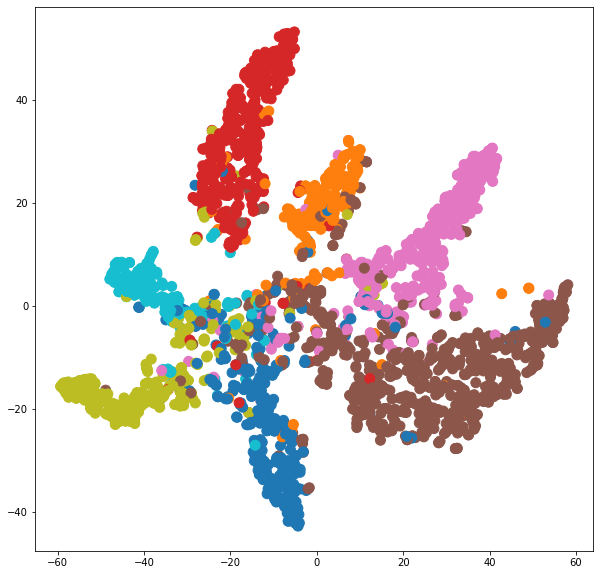

In [ ]:
def plot_embedding2D(h, color=data.y, size=100):
    h = h.detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=500, verbose=False).fit_transform(h)
    fig = plt.figure(figsize=(10, 10))
    plt.set_cmap("tab10")
    plt.scatter(h[:, 0], h[:, 1], c=color, s=size)
    plt.show()

# Embedding beore training
plot_embedding2D(best_model_embedding[0])
# Embedding after training
plot_embedding2D(best_model_embedding[-1])

## Experiment #2: SAGE

$$x_{i}^{'} = \Theta_{1} x_{i} + \Theta_{2} \cdot \text{mean}_{j \in \mathcal{N}(i)} x_{j}$$

In [ ]:
from torch_geometric.utils import remove_self_loops, add_self_loops
from torch_sparse import matmul

class SAGEConv(MessagePassing):
    def __init__(self, in_channels, out_channels, aggr="mean"):
        super().__init__(aggr=aggr)
   
        # Linear layer for root node
        self.linear_r = Linear(in_channels, out_channels, bias=False)
        # Linear layer for neighboors
        self.linear_l = Linear(in_channels, out_channels, bias=False)

    def reset_parameters(self):
        self.linear_r.reset_parameters()
        self.linear_l.reset_parameters()
        
    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Convert tensor to OptPairTensor
        x = (x, x)

        x_r = x[1]

        out = self.propagate(edge_index, x=x)
        out = self.linear_r(x_r) + self.linear_l(out)
        #out = F.relu(out)
        out = F.normalize(out, p=2., dim=-1)

        return out

    def message(self, x_j):
        # x_j has shape [E, out_channels]
        return x_j

    def message_and_aggregate(self, adj_t, x):    
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x[0], reduce=self.aggr)

In [ ]:
HIDDEN_DIM = 16
OUTPUT_DIM = dataset.num_classes
DROPOUT = 0.3
EPOCHS = 100
NTRIALS = 10

In [ ]:
class SAGENet(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, p_drop):
        super(SAGENet, self).__init__()
        self.p_drop = p_drop
        self.conv1 = SAGEConv(in_dim, hid_dim)
        self.conv2 = SAGEConv(hid_dim, out_dim)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, x, edge_index):
        h = F.relu(self.conv1(x, edge_index))
        h = F.dropout(h, p=self.p_drop)
        h = self.conv2(h, edge_index)
        h = F.log_softmax(h, dim=1)
        return h

model = SAGENet(dataset.num_features, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

embedding = model(data.x, data.edge_index)
print("Embedding shape:", embedding.shape)

Embedding shape: torch.Size([2708, 7])


In [ ]:
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [ ]:
model.reset_parameters()
history, best_model_weights, best_model_embedding = train(model, optimizer, criterion, data, trials=NTRIALS, epochs=EPOCHS, patience=10, device=device)

model.load_state_dict(best_model_weights)
print()
print(f'Best model predicts with {test(model, data, device=device):.2f} accuracy on test set')

Train: model=SAGENet, opt=Adam(lr=0.010000), epochs=100, device=cuda:0

Trial 1:
Epoch   1/100, train loss:  2.10, train acc:  0.10, val loss:  1.72, val acc:  0.46
Epoch  10/100, train loss:  1.33, train acc:  0.89, val loss:  1.41, val acc:  0.75
Epoch  20/100, train loss:  1.24, train acc:  0.95, val loss:  1.33, val acc:  0.83
Epoch  30/100, train loss:  1.19, train acc:  0.97, val loss:  1.32, val acc:  0.82
Early stopping: stop training
Trial 2:
Epoch   1/100, train loss:  1.96, train acc:  0.18, val loss:  1.69, val acc:  0.47
Epoch  10/100, train loss:  1.25, train acc:  0.95, val loss:  1.35, val acc:  0.80
Epoch  20/100, train loss:  1.20, train acc:  0.96, val loss:  1.31, val acc:  0.84
Epoch  30/100, train loss:  1.17, train acc:  0.97, val loss:  1.30, val acc:  0.84
Early stopping: stop training
Trial 3:
Epoch   1/100, train loss:  2.00, train acc:  0.14, val loss:  1.75, val acc:  0.38
Epoch  10/100, train loss:  1.30, train acc:  0.91, val loss:  1.40, val acc:  0.78
E

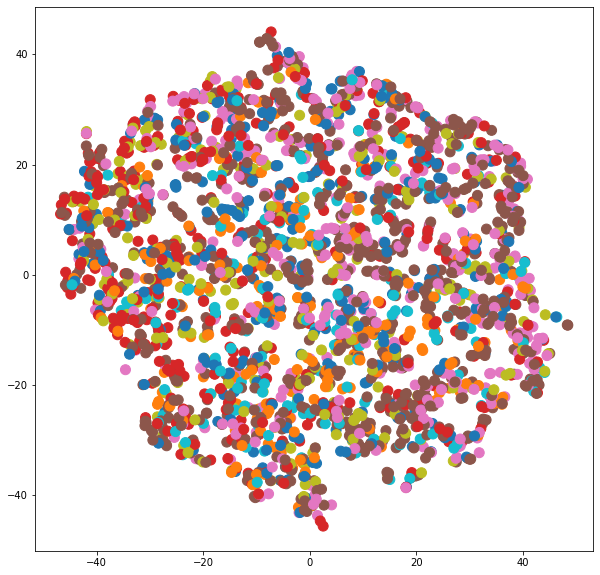

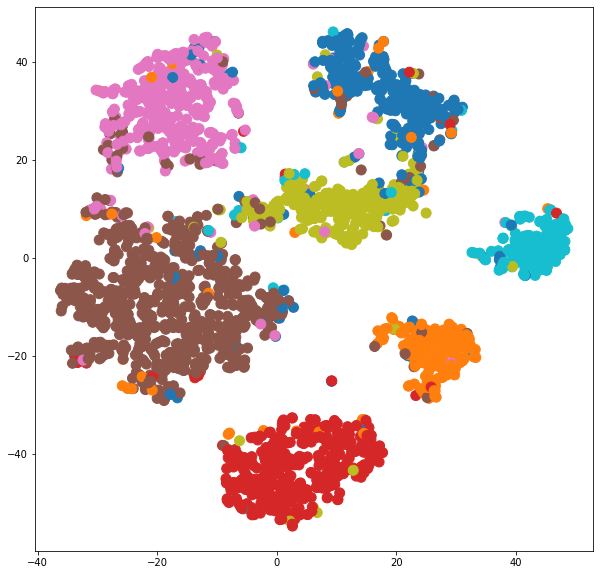

In [ ]:
def plot_embedding2D(h, color=data.y, size=100):
    h = h.detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=500, verbose=False).fit_transform(h)
    fig = plt.figure(figsize=(10, 10))
    plt.set_cmap("tab10")
    plt.scatter(h[:, 0], h[:, 1], c=color, s=size)
    plt.show()

# Embedding beore training
plot_embedding2D(best_model_embedding[0])
# Embedding after training
plot_embedding2D(best_model_embedding[-1])

The following function is used to have an animation of how the learning process work and the embeddings in 2d space evolve

In [ ]:
def animate(i):
    ax.clear()
    h = best_model_embedding[i]
    h = h.detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=500, verbose=False).fit_transform(h)
    ax.scatter(h[:, 0], h[:, 1], c=data.y, s=100)
    train_loss = history['loss'][i]
    ax.set_title(f'Epoch: {i+1}, Loss: {train_loss:.4f}')

fig = plt.figure(figsize=(10, 10))
plt.set_cmap("tab10")
ax = plt.axes()
anim = animation.FuncAnimation(fig, animate, frames=len(best_model_embedding))
plt.close()

#video = anim.to_html5_video()
#html_code = display.HTML(video)
#display.display(html_code)

gif_writer = animation.PillowWriter(fps=1)
anim.save('embeddings.gif', writer=gif_writer)

## Experiment #3: GAT



Popular GNN architectures weigh all neighbors $j \in N_{i}$ with equal importance (e.g., mean or max-pooling as AGGREGATE). To
address this limitation, GAT computes a score
for every edge $(j, i)$, which indicates the importance of the features of the neighbor $j$ to the node $i$.

GAT convolution is matematically defined as:

$$ x_{i}^{'} = \alpha_{i,j} \Theta x_{i} + \sum_{j \in \mathcal{N}(i)} \alpha_{i,j} \Theta x_{j}$$

the scoring function is defined as:

$$ e(x_{i}, x_{j}) =  \text{LeakyReLU}(a^\top \cdot [\Theta x_{i} || \Theta x_{j}]) $$

and is used to compute the attention coefficients:

$$ \alpha_{i,j} = \text{softmax}_{j}(e(x_{i}, x_{j})) =  \frac{\exp(e(x_{i}, x_{j}))}{\sum_{j^{'} \in \mathcal{N}} \exp(e(x_{i}, x_{j^{'}}))} $$


The main problem in the standard GAT scoring function  is that the learned layers $\Theta$ and $a$ are applied consecutively, and thus can be collapsed into a single linear layer. To fix
this limitation, in GATv2 the $a$ layer is applied after the nonlinearity (LeakyReLU), and the $\Theta$ layer
after the concatenation, effectively applying an MLP to compute the score for each query-key pair:

$$ e(x_{i}, x_{j}) =  a^\top \text{LeakyReLU}(\Theta \cdot [x_{i} ||  x_{j}]) $$

In [ ]:
from torch_geometric.nn.conv import GATv2Conv

In [ ]:
from torch_geometric.nn.dense.linear import Linear

class GATNet(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, p_drop, n_heads=3):
        super(GATNet, self).__init__()
        self.p_drop = p_drop
        self.n_heads = n_heads
        self.conv1 = GATv2Conv(in_dim, hid_dim, 8)
        self.conv2 = GATv2Conv(hid_dim*8, out_dim, 1, concat=False)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, x, edge_index):
        h = F.relu(self.conv1(x, edge_index))
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.conv2(h, edge_index)
        h = F.log_softmax(h, dim=1)
        return h

model = GATNet(dataset.num_features, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

embedding = model(data.x, data.edge_index)
print("Embedding shape:", embedding.shape)

Embedding shape: torch.Size([2708, 7])


In [ ]:
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

history, best_model_weights, best_model_embedding = train(model, optimizer, criterion, data, trials=NTRIALS, epochs=EPOCHS, patience=10, device=device)

model.load_state_dict(best_model_weights)
print()
print(f'Best model predicts with {test(model, data, device=device):.2f} accuracy on test set')

Train: model=GATNet, opt=Adam(lr=0.010000), epochs=100, device=cuda:0

Trial 1:
Epoch   1/100, train loss:  1.93, train acc:  0.18, val loss:  1.60, val acc:  0.34
Epoch  10/100, train loss:  0.30, train acc:  0.90, val loss:  0.41, val acc:  0.87
Epoch  20/100, train loss:  0.11, train acc:  0.96, val loss:  0.48, val acc:  0.87
Early stopping: stop training
Trial 2:
Epoch   1/100, train loss:  1.94, train acc:  0.19, val loss:  1.83, val acc:  0.34
Epoch  10/100, train loss:  0.44, train acc:  0.88, val loss:  0.48, val acc:  0.86
Epoch  20/100, train loss:  0.14, train acc:  0.95, val loss:  0.47, val acc:  0.88
Early stopping: stop training
Trial 3:
Epoch   1/100, train loss:  1.95, train acc:  0.15, val loss:  1.86, val acc:  0.46
Epoch  10/100, train loss:  0.45, train acc:  0.88, val loss:  0.50, val acc:  0.86
Epoch  20/100, train loss:  0.19, train acc:  0.94, val loss:  0.51, val acc:  0.86
Early stopping: stop training
Trial 4:
Epoch   1/100, train loss:  1.95, train acc:  0

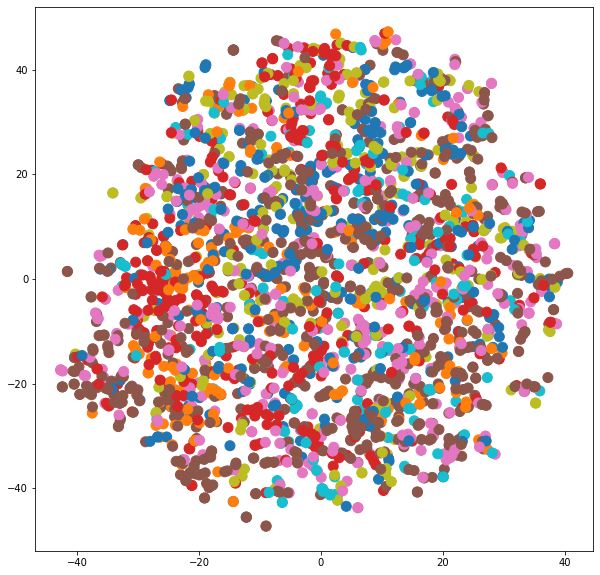

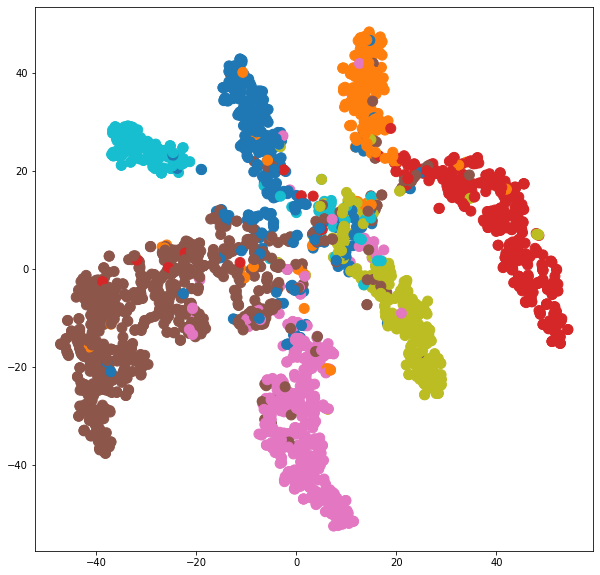

In [ ]:
def plot_embedding2D(h, color=data.y, size=100):
    h = h.detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=500, verbose=False).fit_transform(h)
    fig = plt.figure(figsize=(10, 10))
    plt.set_cmap("tab10")
    plt.scatter(h[:, 0], h[:, 1], c=color, s=size)
    plt.show()

# Embedding beore training
plot_embedding2D(best_model_embedding[0])
# Embedding after training
plot_embedding2D(best_model_embedding[-1])